In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_logistic_regression"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

In [3]:
def scale_columns(dataframe, columns_to_scale):
    # Work on a copy to avoid modifying the original DataFrame
    df_scaled = dataframe.copy()
    for column in columns_to_scale:
        # Scale each specified column individually
        df_scaled[column] = stats.zscore(df_scaled[column])
    return df_scaled

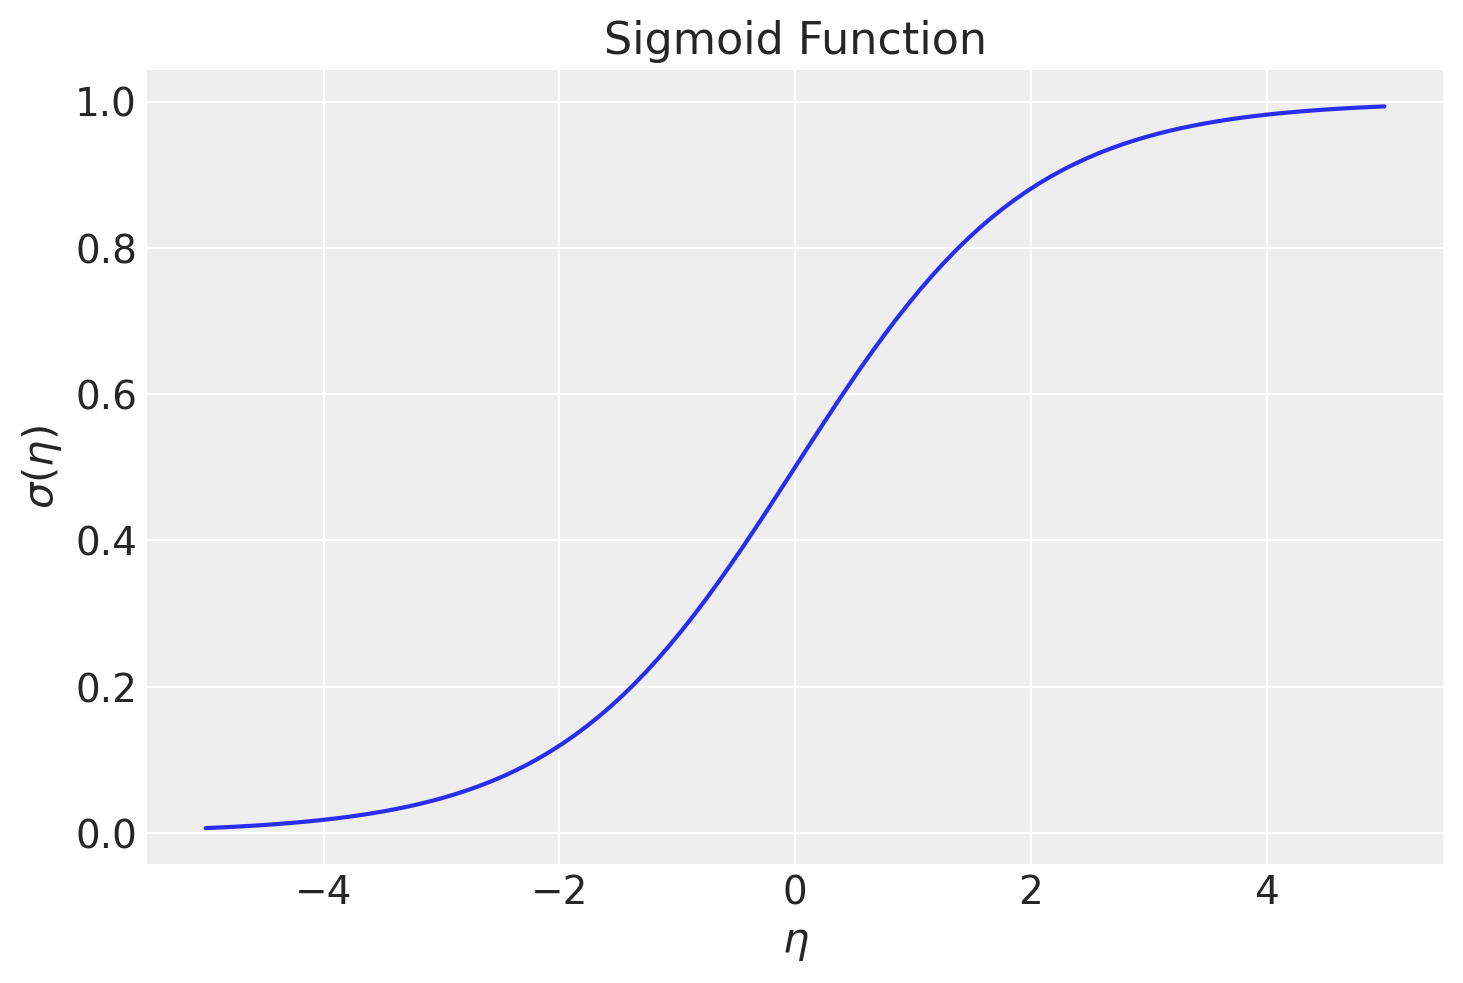

In [4]:
# Define the range for z
z = np.linspace(-5, 5, 100)

# Plot the sigmoid function
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\sigma(\eta)$")  
plt.title("Sigmoid Function")
plt.grid(True)
plt.show()

In [5]:
clinton_data = pd.read_csv("../data/clinton.csv")
clinton_data.dropna(inplace=True)
clinton_data = clinton_data.query("vote != 'someone_else'")
clinton_data.head()

,Unnamed: 0,vote,age,party_id
0,0,clinton,56,democrat
1,1,trump,65,republican
2,2,clinton,80,democrat
3,3,trump,38,republican
4,4,trump,60,republican


In [6]:
# Conversione dei valori nella colonna 'vote'
clinton_data['vote'] = clinton_data['vote'].replace({'clinton': 1, 'trump': 0})
clinton_data['vote'] = clinton_data['vote'].astype(int)
clinton_data.head()

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_33711/1878734763.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinton_data['vote'] = clinton_data['vote'].replace({'clinton': 1, 'trump': 0})


,Unnamed: 0,vote,age,party_id
0,0,1,56,democrat
1,1,0,65,republican
2,2,1,80,democrat
3,3,0,38,republican
4,4,0,60,republican


In [7]:
clinton_data["vote"].value_counts()

vote
1    215
0    158
Name: count, dtype: int64

In [8]:
columns_to_scale = ['age']
scaled_df = scale_columns(clinton_data, columns_to_scale)
scaled_df.head()

,Unnamed: 0,vote,age,party_id
0,0,1,0.392692,democrat
1,1,0,0.916229,republican
2,2,1,1.788790,democrat
3,3,0,-0.654382,republican
4,4,0,0.625375,republican


In [9]:
scaled_df['vote'] = pd.to_numeric(scaled_df['vote'], errors='coerce')
data_matrix = scaled_df[['vote']]
data_matrix.shape

(373, 1)

In [10]:
stan_data = {
    "N" : data_matrix.shape[0],
    "y" : scaled_df['vote'].astype(int),
    "x" : scaled_df["age"] 
}

In [11]:
stan_file = os.path.join('stan', 'logistic_regression.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N;
  vector[N] x;
  array[N] int<lower=0, upper=1> y;
}
parameters {
  real alpha;
  real beta;
}
model {
  y ~ bernoulli_logit(alpha + beta * x);
}



In [12]:
model = CmdStanModel(stan_file=stan_file)

In [13]:
fit = model.sample(data=stan_data)

09:49:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:49:27 - cmdstanpy - INFO - CmdStan done processing.


In [14]:
az.summary(fit, var_names=(["alpha", "beta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.318,0.107,0.112,0.533,0.002,0.001,3041.0,2298.0,1.0
beta,-0.310,0.109,-0.518,-0.088,0.002,0.001,2881.0,2756.0,1.0


In [15]:
new_data = pd.DataFrame({
    "age": np.linspace(18, 90, 100)
})
new_data

,age
0,18.000000
1,18.727273
2,19.454545
3,20.181818
4,20.909091
...,...
95,87.090909
96,87.818182
97,88.545455
98,89.272727


In [16]:
alpha = fit.stan_variable('alpha').mean()
beta = fit.stan_variable('beta').mean() 

In [17]:
beta

-0.30966114531075

In [18]:
# Calcola le probabilità logit per ogni età in `new_data`
logit_p = alpha + new_data['age'] * beta
logit_p

0     -5.255671
1     -5.480879
2     -5.706087
3     -5.931295
4     -6.156503
        ...    
95   -26.650441
96   -26.875649
97   -27.100857
98   -27.326065
99   -27.551273
Name: age, Length: 100, dtype: float64

In [19]:
new_data['logit_p'] = logit_p

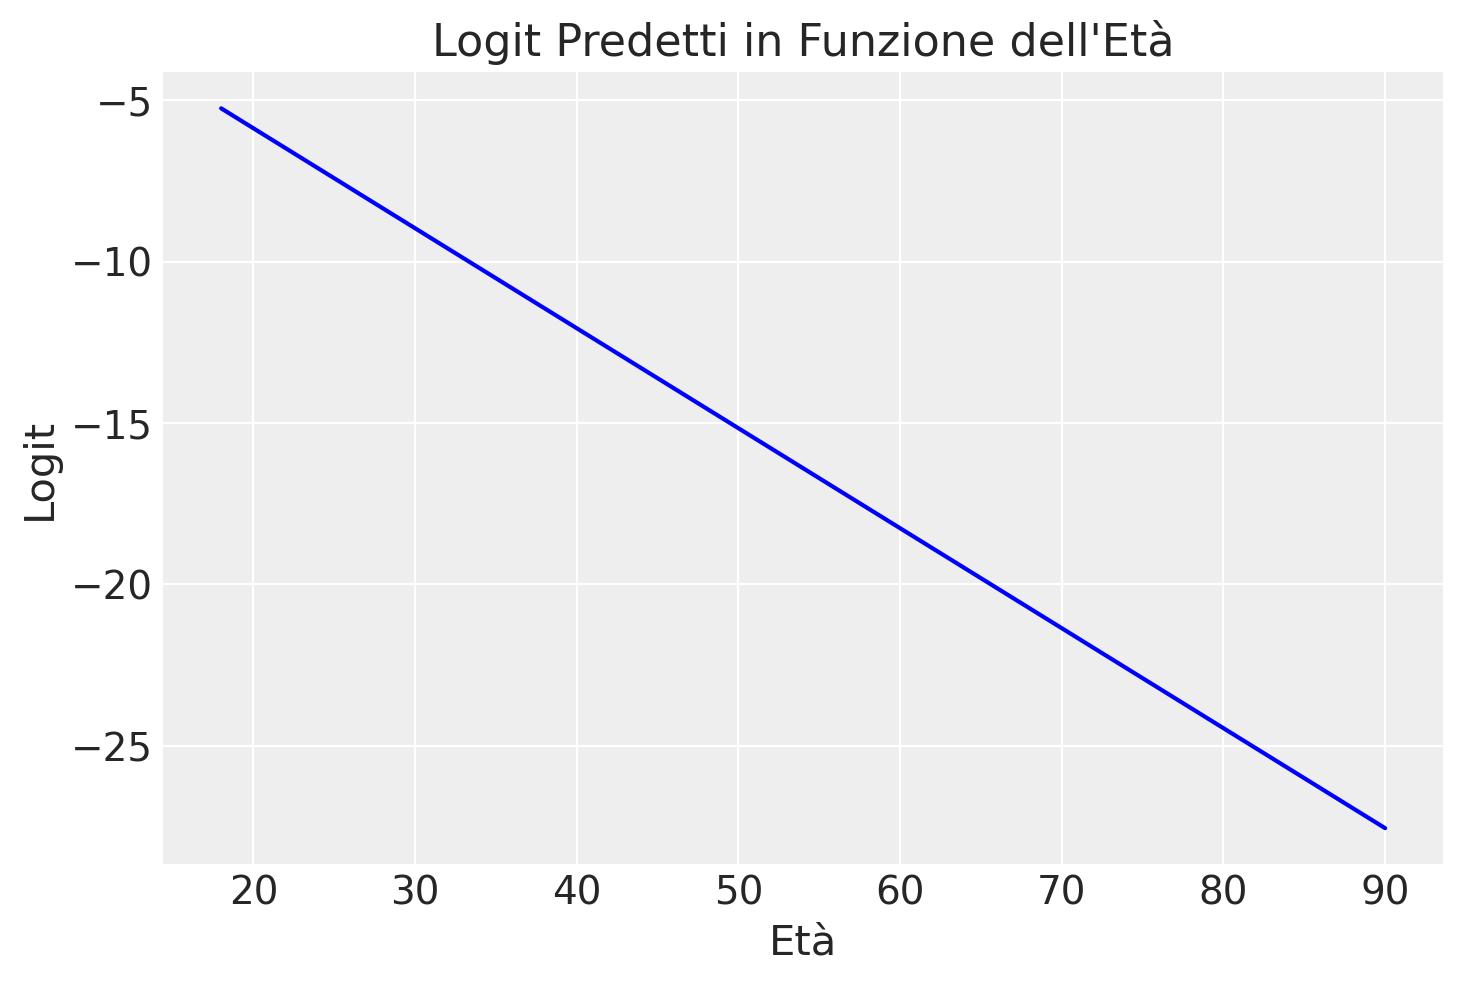

In [20]:
plt.plot(new_data['age'], new_data['logit_p'], linestyle='-', color='blue')  # Plot con marcatori e linea

plt.title('Logit Predetti in Funzione dell\'Età')  # Titolo del grafico
plt.xlabel('Età')  # Etichetta asse x
plt.ylabel('Logit')  # Etichetta asse y
plt.show() 

In [21]:
# Converti logit in probabilità usando la funzione logistica (expit)
prob = expit(logit_p)
# Aggiungi le probabilità calcolate a `new_data`
new_data['prob'] = prob

In [22]:
new_data.describe()

,age,logit_p,prob
count,100.000000,100.000000,1.000000e+02
mean,54.000000,-16.403472,2.580097e-04
std,21.099267,6.533623,8.278357e-04
min,18.000000,-27.551273,1.083014e-12
25%,36.000000,-21.977373,2.866388e-10
50%,54.000000,-16.403472,7.565021e-08
75%,72.000000,-10.829571,1.990258e-05
max,90.000000,-5.255671,5.190760e-03


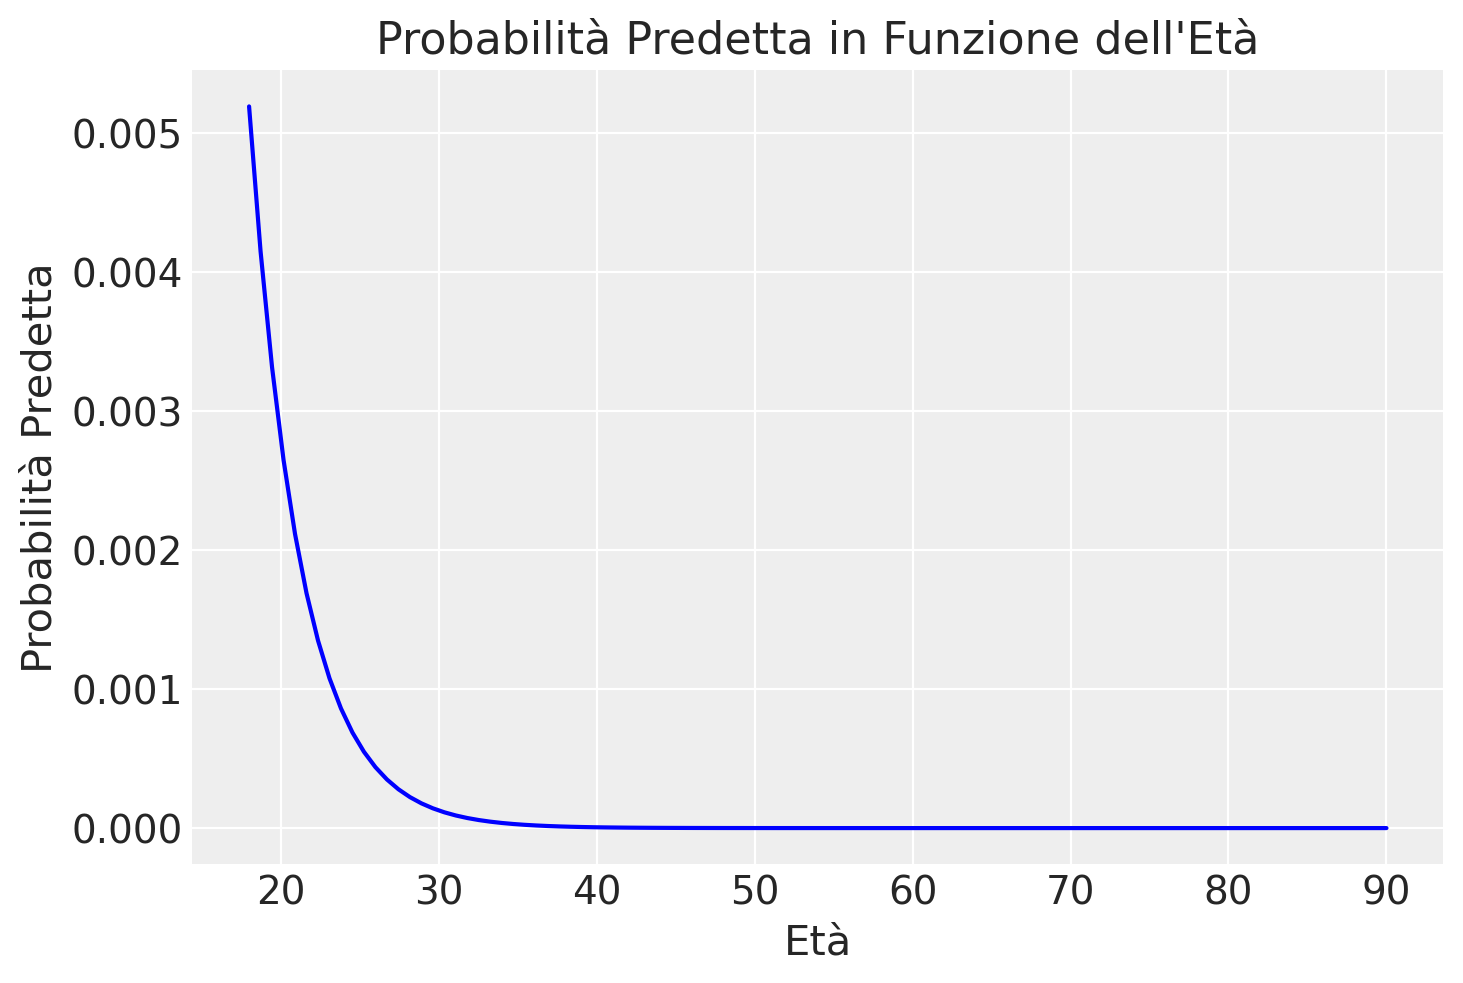

In [23]:
plt.plot(new_data['age'], new_data['prob'], linestyle='-', color='blue')  # Plot con marcatori e linea

plt.title('Probabilità Predetta in Funzione dell\'Età')  # Titolo del grafico
plt.xlabel('Età')  # Etichetta asse x
plt.ylabel('Probabilità Predetta')  # Etichetta asse y
plt.show() 

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanp

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

cmdstanp: not installed

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
arviz     : 0.18.0
scipy     : 1.13.1
matplotlib: 3.8.4
seaborn   : 0.13.2
numpy     : 1.26.4

Watermark: 2.4.3

